In [1]:
import torch
import time

import sys
import os
sys.path.insert(0, os.path.abspath("../marl_env"))

from matplotlib import pyplot as plt
from trainer import DeepQTrainer
from environment import MultiAgentEnvironment

%matplotlib inline

/Users/BenjaminSuter/Documents/My Files/COSS/agent_env/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Indicate what agents you want to participate in the market by providing an agent dictionary

In [2]:
agent_dict = {
    'sellers': {
        1: {
            'type': 'HumanReplayAgent',
            'reservation': 68,
            'multiplicity': 1,
            **{'id': 1022},
        },
    },
    'buyers': {
        1: {
            'type': 'DQNAgent',
            'reservation': 128,
            'multiplicity': 1,
            **{'lr': 0.005,}
        },
    }
}

Now initialize your environment. Agents are provided via the agent dictionary.
Market setting, Information setting, Exploration setting and Reward setting can be optionally provided via a string.
Additional parameters fine tuning the above settings can be provided as a keyword arguments dictionary --> kwargs

In [3]:
kwargs = {
    'market_settings': {},
    'info_settings': {},
    'exploration_settings': {'n_expo_steps': 100,
                             'final_expo': 0.05},
    'reward_settings': {'no_deal_max': 1}
}

env = MultiAgentEnvironment(
    agent_dict,
    'MarketMatchHiLo',
    'BlackBoxSetting',
    'LinearExplorationDecline',
    'NoDealPenaltyReward',
    **kwargs
)

Environment running on default CPU setting --> No GPU was found

Initialising HumanReplayAgent
-- role: seller
-- reservation: 68
-- data_path: ../HumanReplayData/NewData/new_data.csv
-- treatment: FullLimS
-- id: 1022

Initialising DQNAgent
-- role: buyer
-- reservation: 128
-- Dealing with agent: DQNAgent_buyer_1
-- lr: 0.005
-- save_weights_directory: ../saved_agent_weights/default_path/DQNAgent_buyer_1/
-- save_weights_file: default_test_file.pt



Now set all training parameters and initialize the trainer.
--> Training parameters are not yet fine tuned...
We can again change optional training parameters via a keyword arguments dictionary. Look at __init__ of the trainer.

In [4]:
n_episodes = 200
batch_size = 16
mem_size = 150
start_size = 100

train_params = {'discount': 0.3,
                'update_frq': 250,
                'loss_min': -50,
                'loss_max': 50,
                'save_weights': True}

trainer = DeepQTrainer(env, mem_size, start_size, **train_params)

We can train the agents by making use of the trainer.train(...) methode.
Training for 200 games will take a few seconds.

In [5]:
tt = time.time()
total_loss, total_rew, actions = trainer.train(n_episodes, batch_size)
print("Total time in s: ", time.time() - tt)

tot_loss = torch.stack(total_loss, dim=0).transpose(0, 1).detach()
tot_rew = torch.stack(total_rew, dim=0).squeeze().transpose(0, 1).detach()
actions = torch.stack(actions, dim=0).transpose(0, 1).detach()

Saving model weights
-- HumanReplayAgent_seller_1 has no model weights that can be saved... passing
-- Saving model weights for DQNAgent_buyer_1

Total time in s:  5.064537048339844


Let's see what the agent has learned...

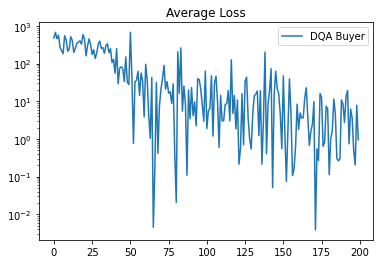

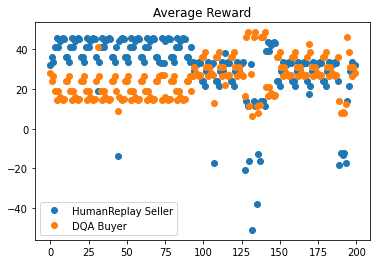

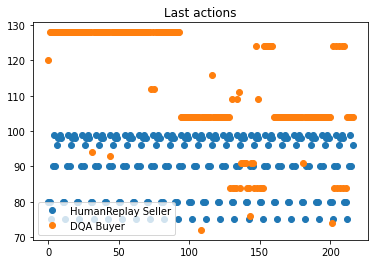

In [6]:
plt.figure()
plt.title("Average Loss")
plt.semilogy(tot_loss[1, :], label="DQA Buyer")
plt.legend()
plt.show()

plt.figure()
plt.title("Average Reward")
plt.plot(tot_rew[0, :], 'o', label="HumanReplay Seller")
plt.plot(tot_rew[1, :], 'o', label="DQA Buyer")
plt.legend()
plt.show()

plt.figure()
plt.title("Last actions")
plt.plot(actions[0, :], 'o', label="HumanReplay Seller")
plt.plot(actions[1, :], 'o', label="DQA Buyer")
plt.legend()
plt.show()